First we generate the data the we train on. In this case a 1D burgers equation solver using a spectral fourier method. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.integrate import solve_ivp

#Creating data by solving the burgers equation in 1D
def init_KS(x,t=0):
    u = (1+np.sin(x/10))
    return u
def Fourier_n(u, Omega,n):
    u_hat = (1j*Omega)**n*fft(u)
    u_hat = ifft(u_hat)
    return u_hat

N = 1000
L = 2
x = np.linspace(-L/2, L/2, N, endpoint=False)

n = fftfreq(N)*N
scale = 2*np.pi/L
Omega = scale*n
u0 = -np.sin(np.pi*x)

def burgers(u, Omega,nu):
    dudt = -0.5*Fourier_n(u*u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    return np.real(dudt)

tend = 0.5
tspan = [0, tend]
nu = 0.01/np.pi
t_len = 3000
tmeasurements = np.linspace(0, tend, t_len)
sol = solve_ivp(lambda t, u: burgers(u, Omega,nu),tspan, u0, t_eval=tmeasurements)
data = sol.y.T


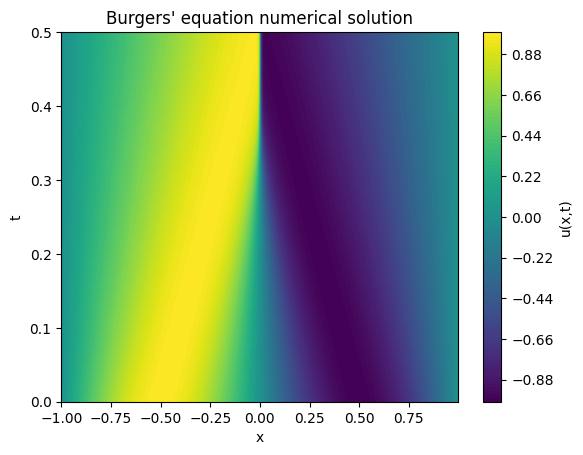

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.contourf(x,sol.t,data, 100, cmap="viridis")
plt.title("Burgers' equation numerical solution")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar(label='u(x,t)')

plt.show()



## SHRED

Now we initialize the SHRED data setup. 

In [3]:
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig
# import pyshred
manager = DataManager(
    lags=50,          # 
    train_size=0.8,   # 80% for training We take 80% from the start 0,1,2,3... 
    val_size=0.1,     # 10% for validation Then comes val 10% from where train ends.
    test_size=0.1     # 10% for testing Lastly comes test.

)
x1 = -0.60
x2 = -0.05
x3 = 0.5

sensor_locs = [np.argmin(x< x1),np.argmin(x< x2),np.argmin(x< x3)]
manager.add_data(
    data=data,         # Must have time as the first index of the data. 
    id="burger",          # Unique identifier for the dataset
    # random=10,          # Randomly select 3 sensor locations
    stationary = [(sensor_locs[0],),(sensor_locs[1],),(sensor_locs[2],)],
    compress=False     # Keep original spatial resolution (no compression)
)

# Prepare the datasets and get train, val and test
train_dataset, val_dataset, test_dataset= manager.prepare()

#initialize the SHRED model
shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

DeviceConfig(device_type = 'cuda') # Set up device to use GPU


DeviceConfig(device_type='cuda', device_id=None, force_cpu=False, warn_on_fallback=True)

# Now we fit the model!

In [4]:
for test, _ in train_dataset:
    print(test.shape)
    break

torch.Size([50, 3])


In [7]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=60,
    batch_size= 64,
    verbose = True,
    lr = 0.0003
)

train_mse = shred.evaluate(dataset=train_dataset) #Mse stands for mean over every element. It is the summed loss divided by the number of elements.
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Fitting SHRED...
Epoch 1: Average training loss = 0.224583
Validation MSE (epoch 1): 0.147208
Epoch 2: Average training loss = 0.147263
Validation MSE (epoch 2): 0.208714
Epoch 3: Average training loss = 0.120475
Validation MSE (epoch 3): 0.227872
Epoch 4: Average training loss = 0.111585
Validation MSE (epoch 4): 0.222066
Epoch 5: Average training loss = 0.111612
Validation MSE (epoch 5): 0.218458
Epoch 6: Average training loss = 0.111975
Validation MSE (epoch 6): 0.218065
Epoch 7: Average training loss = 0.111576
Validation MSE (epoch 7): 0.218764
Epoch 8: Average training loss = 0.110580
Validation MSE (epoch 8): 0.217593
Epoch 9: Average training loss = 0.110502
Validation MSE (epoch 9): 0.219707
Epoch 10: Average training loss = 0.109121
Validation MSE (epoch 10): 0.218868
Epoch 11: Average training loss = 0.106586
Validation MSE (epoch 11): 0.207121
Epoch 12: Average training loss = 0.094316
Validation MSE (epoch 12): 0.079240
Epoch 13: Average training loss = 0.068783
Validation

# Training complete and we move to downstream tasks.

In [8]:
engine = SHREDEngine(manager, shred) #Initialize the SHRED engine used for downstream tasks

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

# generate latent states from validation sensor measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)

# seed the forecaster with the final `seed_length` latent states from validation
init_latents = val_latents[-shred.latent_forecaster.seed_length:] # seed forecaster with final lag timesteps of latent space from val

# set forecast horizon to match the length of the test dataset
h = len(manager.test_sensor_measurements)

# forecast latent states for the test horizon
test_latent_from_forecaster = engine.forecast_latent(h=h, init_latents=init_latents)



In [9]:
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)

# decode latent space generated by the latent forecaster (generated using engine.forecast_latent())
test_forecast = engine.decode(test_latent_from_forecaster)

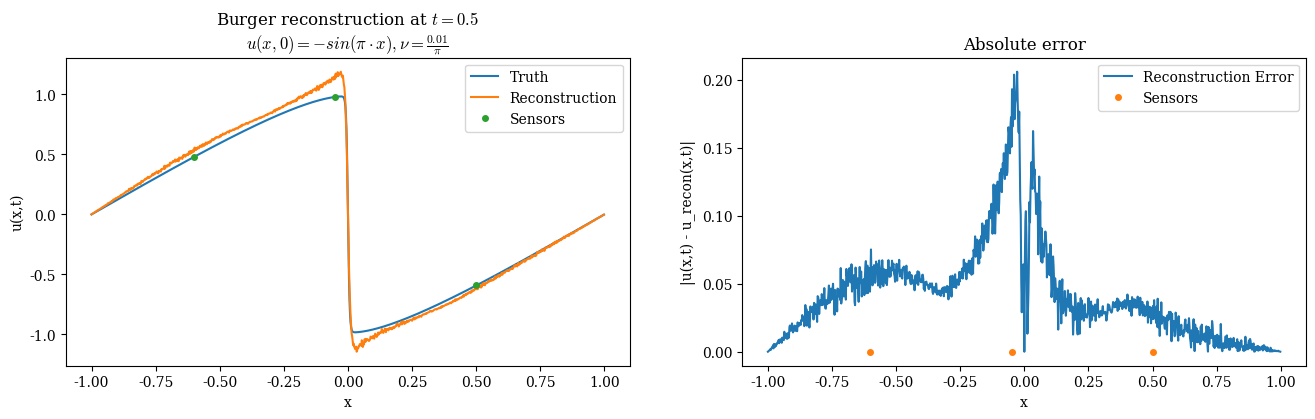

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",       # Computer Modern for math
    "axes.unicode_minus": False,    # So minus sign appears correctly
})
index = -(1)
# Final ground truth frame from the test set
truth = data[index]

# Extract final reconstructed frame (from sensor-based latents)
reconstructions = test_reconstruction["burger"]
reconstruction = reconstructions[index]

# Extract final forecasted frame (from forecasted latents)
forecasts = test_forecast["burger"]
forecast = forecasts[index]

# Collect data and labels for visualization
compare_data = [truth, reconstruction, forecast]
titles = ["Test Ground Truth", "SHRED Reconstruction", "SHRED Forecast"]


# Create side-by-side comparison plot
fig,ax = plt.subplots(1,2, figsize=(16,4))
ax[0].plot(x,truth, label = 'Truth')
ax[0].plot(x,reconstruction,label = 'Reconstruction')
# ax[0].plot(x,forecast,label = 'forecast')
ax[0].plot(x[sensor_locs],truth[sensor_locs],'o', label = 'Sensors',markersize = 4)
ax[0].set_xlabel(r'x')
ax[0].set_ylabel(r'u(x,t)')
ax[0].legend()
ax[1].plot(x,abs(truth-reconstruction), label = 'Reconstruction Error')
ax[1].plot(x[sensor_locs],np.zeros(3),'o', label = 'Sensors',markersize = 4)
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'|u(x,t) - u_recon(x,t)|')
ax[1].legend()
ax[1].set_title('Absolute error')
ax[0].set_title(r'''Burger reconstruction at $t = 0.5$
$u(x,0) = -sin(\pi\cdot x), \nu = \frac{0.01}{\pi}$''')
plt.show()

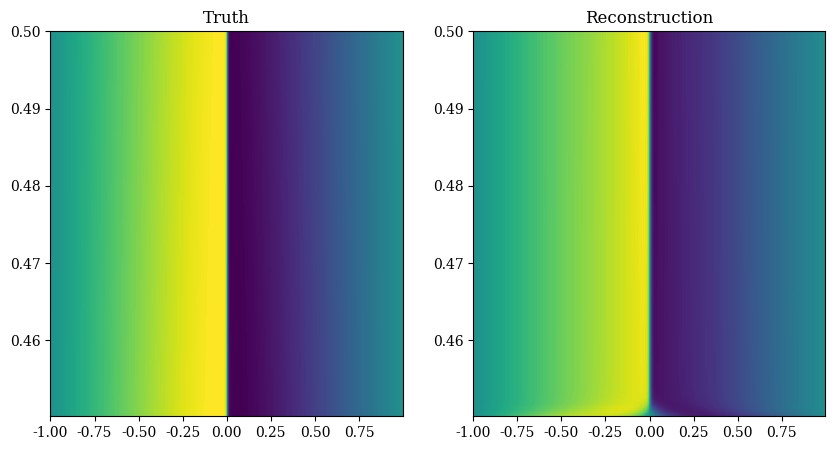

In [12]:
# Reconstructing the full domain
full_truth_test = data[-t_test:]
time_test = sol.t[-t_test:]



fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(x,time_test,full_truth_test, levels=200, cmap="viridis")
ax[1].contourf(x,time_test,reconstructions, levels=200, cmap="viridis")
ax[0].set_title('Truth')
ax[1].set_title('Reconstruction')
plt.show()
